# Topic of the course

In this practical course, you will explore the behavior of expert mice doing the IBL task. Mice perform the task one time a day, and we call this a behavioral training *session*.

We will explore together some responses of the mice, and then you will select one of these projects:
- Do male mice respond faster than female mice?
- Does training at late time in the day impact on performance?

# Introduction: What data will be used

We will use three [pandas dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):
- `df_subjects` that contains the information on the mouse, which we call subject, for example its name, its date of birth
- `df_sessions` that contains the information on the behavioral sessions made by each subject, for example the start time of the session
- `df_trials` that contains the information for each trials of the sessions, for example the time of the go cue

These dataframes will contain the information of over 300+ sessions, for over 100+ mice.

## Download the datasets
Use this [script](../behavior_course/scripts/data_loading.py) to download the data. Set the `LOCAL_DATA_PATH` to a folder on your machine where you want the data downloaded.

## Technical references
Before starting the analysis, get familiar with :
- [pandas dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)


# Step 1: Explore the data

## Using the visualisation website

You can view the session using the visualisation website, and scrolling down to the session overview page.
You can write a mouse name in the search bar (note that one mouse may have several sessions).

- We use here one [example session](https://viz.internationalbrainlab.org/app?dset=bwm&pid=53ecbf4f-e0d8-4fe6-a852-8b934a37a1c2&tid=0&cid=1399&qc=0) of subject `KS014`

![Viz webpage: session overview](../behavior_course/images/behaviour_overview_PID_53ecbf4f-e0d8-4fe6-a852-8b934a37a1c2.png)

Do you notice that the mouse reaction time increases over the course of the session?

Further down the page, you can observe the timing between events (stim on, first move etc) at each trial; click on the left-image to see a particular trial of interest:

![Viz webpage: trial overview](../behavior_course/images/trial-0153.png)
Look at the first 3 trials, and the last 3 trials during the session. Do you notice any difference?

You can also see the mouse performing the task in real time, and get a sense for how the task enfolds using the panel below ; you can click and drag the center view to explore the environment the mouse is behaving in.

![Viz webpage: setup](../behavior_course/images/behavior_video.png)
Look at the contrast on the screen, and pretend you are doing the task in your mind. Would you have been as fast as the mouse to react and place the stimulus in the center?

# Step 2: Select a project

## Project 1: Do male mice respond faster than female mice?

In this project, we are interested to know whether female mice respond differently than male mice. This is important, because we want to pool data across mice and make generalised conclusion. Therefore, we need to know whether their behavior is indistinguishable. To study this, we will look at the reaction time in trials where the animals responded either correctly or incorrectly.

In this project, you will first:
- Learn how to search the dataframes for male or female subjects
- Learn how to compute reactions times
- Learn how to study reaction times in correct versus incorrect trials
- Explore the trend of the reaction times across a session, by viewing the reaction times across trials, for an example session from either a female or male mice

Then, you will be tasked to:
- Visualise whether the reaction times across trials shows a different trend for female and male mice
- Find a good epoch in the session, and a good metric, to perform the comparison. For example, per mouse, take the first N trials of the session, and compute the median reaction time over it. Compare the median reaction time for male versus female mile

### Loading and visualising the data
Use the pandas `read_parquet` function to load in each dataframe:


In [64]:
import pandas as pd
from pathlib import Path
import numpy as np

LOCAL_PATH = Path('/Users/gaelle/Documents/Work/Course')

# Load the data
df_sess = pd.read_parquet(LOCAL_PATH.joinpath('sessions.pqt'))
df_subj = pd.read_parquet(LOCAL_PATH.joinpath('subjects.pqt'))
df_trial = pd.read_parquet(LOCAL_PATH.joinpath('trials.pqt'))

To know whether a mouse is male or female, look into the column `sex` of the `subjects` dataframe:

In [65]:
print(df_subj.columns)
# We print the unique values from the column sex:
print(np.unique(df_subj['sex']))

Index(['subject', 'subj_id', 'birth_date', 'sex', 'lab'], dtype='object')
['F' 'M']


To compute the reaction time, we will need to use the two variables from the `trials` dataframe:
- the go cue time, found in the colum `goCue_times`
- the response time, found in the column `response_times`

These are the times (in second from the session start) at which the go cue was sent, and a response from the mouse was registered, respectively.

In [66]:
print(df_trial.columns)

df_trial['reaction_time'] = df_trial['response_times'] - df_trial['goCue_times']

Index(['goCueTrigger_times', 'stimOff_times', 'goCue_times', 'response_times',
       'choice', 'stimOn_times', 'contrastLeft', 'contrastRight',
       'probabilityLeft', 'feedback_times', 'feedbackType', 'rewardVolume',
       'firstMovement_times', 'intervals_0', 'intervals_1', 'eid',
       'trial_number'],
      dtype='object')


We will now plot the distribution of reaction time (this is across all sessions and all mice). You can use either a histogram plot, or a kernel density estimate plot:

<Axes: >

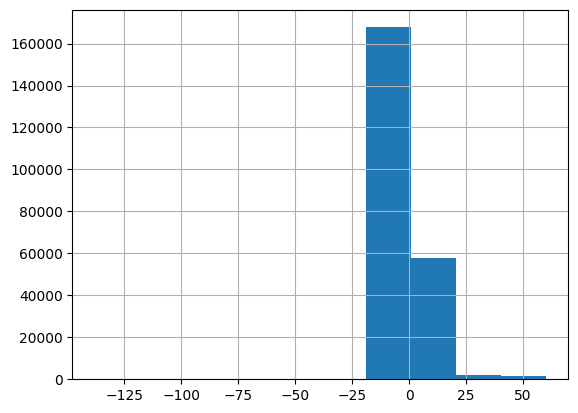

In [67]:
df_trial['reaction_time'].hist()

<Axes: ylabel='Density'>

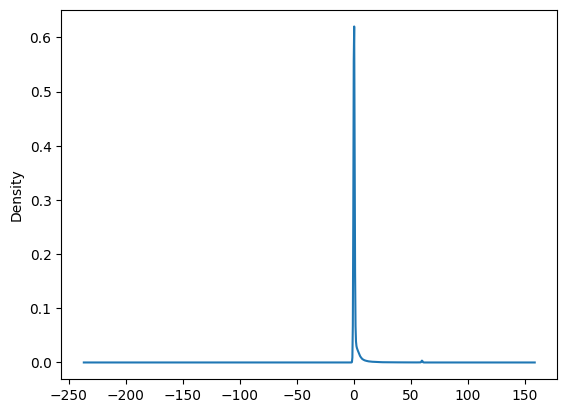

In [78]:
df_trial['reaction_time'].plot(kind='kde')

Did you notice that some reactions times are negative? This can be surprising at first, as this means the mouse made a response before the stimulus was even presented. Let's see how many trials with negative RTs there are:

In [69]:
df_trial_neg_rt = df_trial[df_trial['reaction_time'] < 0]
print(len(df_trial_neg_rt))

575


Let's see if negative reaction times occur in both male and female mice.
First, we need to join the trials and subjects table through the sessions table, to later be able to group by the reaction time values by sex type:

In [70]:
# Merge
df_sess = df_sess.merge(df_subj[['subject', 'sex']], on='subject')
df_trial_neg_rt = df_trial_neg_rt.merge(df_sess[['eid', 'sex']], on='eid')

print(df_trial_neg_rt.columns)  # Notice we added in the 'sex' column

Index(['goCueTrigger_times', 'stimOff_times', 'goCue_times', 'response_times',
       'choice', 'stimOn_times', 'contrastLeft', 'contrastRight',
       'probabilityLeft', 'feedback_times', 'feedbackType', 'rewardVolume',
       'firstMovement_times', 'intervals_0', 'intervals_1', 'eid',
       'trial_number', 'reaction_time', 'sex'],
      dtype='object')


In [71]:
df_trial_neg_rt.groupby('sex')['reaction_time'].count()

sex
F    560
M     15
Name: reaction_time, dtype: int64

There seems to be more negative reaction time in female mice when displaying just this number, however you have to take into account the proportion of female versus male mice (i.e. we may have many more females than males to begin with).
 - Can you find out how many trials there are for female and male mice?
  - And the proportion of trials done by female compared to male mice?
    - Would this proportion explain the difference with see here with negative reaction time?

Let's see if negative reaction times occur at the end or beginning of the session. We generate the histogram of trial number with negative reaction times:

<Axes: >

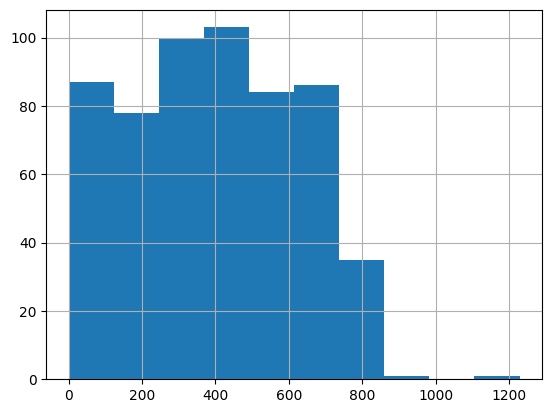

In [72]:
df_trial_neg_rt["trial_number"].hist()

This seems pretty evenly spread. However, this may be confounded by the fact that we look at several mice at once.

To see this histogram distribution for either male and female mice on the same plot, we use `groupby`:

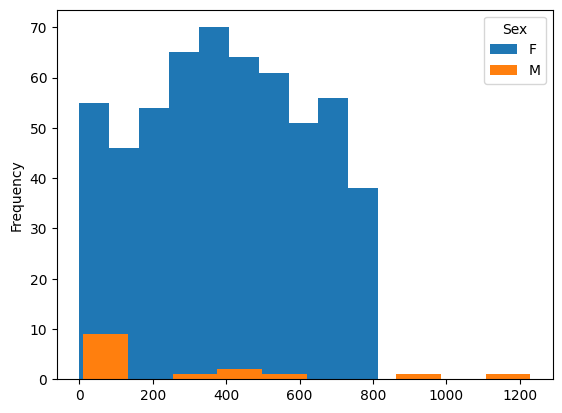

In [80]:
import matplotlib.pyplot as plt
# Note that matplotlib is required to plot the legend

# Plot the histogram of trial numbers for both male and female mice
df_trial_neg_rt.groupby('sex')['trial_number'].plot(kind='hist')

# Add legends for the curves (sex)
plt.legend(df_trial_neg_rt.groupby('sex').sex.dtype.index.to_list(), title='Sex')


You can also use boxplot to reveal the distributions side by side:

trial_number    Axes(0.125,0.11;0.775x0.77)
dtype: object

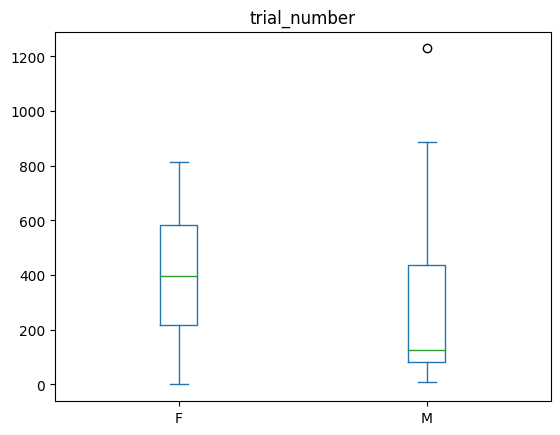

In [81]:
df_trial_neg_rt.plot.box(column="trial_number", by="sex")

- Can you plot the distribution of trial number for negative reaction time per subject?
- How many negative reaction time does each subject do?
- Is there an outlier subject? Can you see if this happens over one, or several session for this outlier?

### Further questions

We have focused on trials with negative reaction times to get you started, however what we really want to know if whether female and male mice respond faster when the reaction time is positive.

- Merge the trials table with the session/subject tables so that it contains the information on `sex` and `subject` name in new columns.
- Create a new trial dataframe with only positive ( `> 0` ) reaction time trials
- Plot the distribution of reaction time for male and female mice using `kde`
-

## Project 2: Does training at late time in the day impact on performance?